# Neural Network Prediction of Sahelian Summer Rainfall
***

#### Resources:
* [Mardata Course](https://github.com/mardatade/Course-Python-for-Machine-Learning/blob/master/3.%20Neural%20Network.ipynb)
* [Keras for Data Scientists](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing)

In [1]:
import numpy as np
import pandas as pd 
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as st

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn import metrics


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

<br>
<br>

## 1. Data Loading & Preprocessing
***

<br>

### a) Loading & Normalization

**pred:** contains the data used for the inputs  <br>
**label:** from Sahelrainfall data serves as validation data

In [2]:
pred = xr.open_dataset('data/da_pred_all.nc').to_dataframe()

pred_unit = pd.DataFrame(
    data = StandardScaler().fit_transform(pred), 
    columns = pred.columns,
    index =  pred.index
)


# load validatoin data (Summer Rainfall over Sahel) 
labels = np.mean(np.loadtxt("data/da_o_sahelprecip19012017.txt", skiprows=8,)[:,7:10] * 0.01,  axis=1)


In [3]:
pred_unit.head()

,siod_e,siod_w,sst_med,tsa,tna,sst_mdr,sata_lnh,sata_lsh,sata_onh,sata_osh,slp_darwin,slp_tahiti,amo,nao,pdo,np,nino12,nino3,nino34,nino4
year,,,,,,,,,,,,,,,,,,,,
1901,-1.100027,-1.152764,-0.745530,-0.595366,0.388372,0.608415,-0.123443,-0.732091,-0.497808,-0.737797,0.074807,1.634819,0.923204,0.917456,-0.193321,1.938388,-0.950168,-0.595561,-0.214314,-0.079270
1902,0.088643,0.340415,-1.507314,-0.954566,-0.346586,-0.173588,-1.289978,-0.201810,-1.175314,-0.987096,1.443896,2.682485,-0.620146,-1.172590,0.819716,-0.162154,0.991321,0.969845,1.099218,1.070532
1903,-0.900789,0.669332,-2.243639,-2.186294,-0.101970,0.283583,-1.333183,-1.076056,-1.415719,-1.333946,-0.071881,1.535042,-0.458290,-1.030410,-0.186187,0.530864,-0.371251,0.000784,0.524139,0.842095
1904,-0.949568,-1.056219,-0.079925,-1.975498,-2.214111,-1.894743,-1.135674,-1.133384,-1.863746,-1.778347,-0.903114,1.235708,-1.872482,1.447076,-0.892459,0.756497,-0.307712,-0.234313,-0.475713,-0.741738
1905,-0.034350,-0.632249,-0.718895,-1.684676,-1.334312,-1.014906,-1.314666,-0.595938,-1.284589,-0.954579,0.759351,-2.655622,-0.499163,-1.289888,0.545055,-0.326007,1.227830,1.497381,1.439037,1.032459


<br>

### b) PCA

### **Question:** normalize pcs again? --> See : [Data loading & preprocessing](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing) 
variance is non-unit for now...\
or does another normalization clear out the information of the pcs?
Badr did not mention anything like that.

In [4]:
# Scikit pca transformation
pca = PCA()
principalComponents = pca.fit_transform(pred_unit)


# Create Create Pandas DF from PCs
col = []
for i in range(1, 21):
    col.append(f'PC{i}')

pred_pc = pd.DataFrame(
    data = principalComponents,
    columns = col,
    index =  pred.index
)

# Test for unit-variance and zero mean:
# np.std(pred_pc)
# np.mean(pred_pc)
# pred_pc.head()

<br>

### c) Select PCs for input and turn into numpy array

In [5]:
features = pred_pc.loc[:,['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC13']].to_numpy()
features.shape

(117, 9)

<br>
<br>

## 2. Build Model
***

### **Question:** Badr says in Table2: '**standard* correlation and error meassures'? --> means standard or standardized?

<br>

## a) RRHCV


### 1.) Define Model

 * Set Layers -> units, activation function, weight decay **note: I just read the reg. below l2 != weight decay**
 * Set loss function and otimizer + learning rate
 * **Parameters that get a default value defined here can be implemented in Grid Search later**

In [6]:
def Buildmodel(reg_factor=1e-2, optimizer='SGD', learn_r=0.01):        
    
    ker_reg=regularizers.l2(reg_factor)
    model = keras.Sequential(
        [
            layers.Dense(3, activation="sigmoid", kernel_regularizer=ker_reg ,name="layer1", input_shape=(9,)),
            layers.Dense(1, activation='linear', kernel_regularizer=ker_reg, name='output') # weight decay for all
        ]
    )
    model.compile(loss='mean_squared_error', optimizer=getattr(keras.optimizers, optimizer)(learning_rate=learn_r))
    return model

<br>

### 2.) Train model and Grid Search Hyper Parameters
For doing GridSearch (or Random Search) the Scikit GridSearchCV function will be used.

This requires the following steps:
1. Use the KerasRegressor wrapper function, so the model will can be handled by the Scikit_learn API
2. Set up a dictionary, where all Parameter values that shall be tried in the model are listed
3. Set-Up GridSerachCV (Crossvalidation with default k-fold=5) --> see code for parameters.  
    I.e. for each combination of Hyperparameters a 5k-fold model cross validation will be performed. <br>
    The parameters will ranked by the mean validation score 'mean_test_score' as printed below
4. For now Cross validation is applied on the full data set (see question in Mattermost)

In [14]:
model = KerasRegressor(build_fn=Buildmodel,epochs=100, batch_size=1, verbose=1)


# define the grid search parameters
param_grid = {
#     'reg_factor': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
#     'optimizer': ['SGD', 'ADAM'],
    'learn_r': [1e-4, 1e-3, 1e-2], #, 1e-1],
#     'batch_s': [1, 2, 3, 5, 10, 20],
     'epochs': [80, 120, 150]
    }

# setup the gridsearch environment by default 
grid = GridSearchCV(estimator=model, # the model that will be used
                    param_grid=param_grid, 
                    n_jobs=-1, # number of parallel processes --> -1 will use all processor cores
                    scoring=None, #if None earlier defined loss function will be passsed through
                    #'neg_mean_squared_error',
#                     {
#                         'Mean_AE': [metrics.mean_absolute_error],
#                         'Median_AE': [metrics.median_absolute_error],
#                         'MSE': [metrics.mean_squared_error(squared=True)],
#                         'RMSE': [metrics.mean_squared_error(squared=False)],
#                     },
#                     cv=7
                    return_train_score=True #training score values will be saved for over/under fitting evaluation 
                   )

In [15]:
grid.fit(features, labels)

Epoch 1/80
117/117 [==============================] - 0s 478us/step - loss: 6.2446
Epoch 2/80
117/117 [==============================] - 0s 504us/step - loss: 4.9762
Epoch 3/80
117/117 [==============================] - 0s 502us/step - loss: 4.3828
Epoch 4/80
117/117 [==============================] - 0s 493us/step - loss: 4.0728
Epoch 5/80
117/117 [==============================] - 0s 503us/step - loss: 3.8920
Epoch 6/80
117/117 [==============================] - 0s 494us/step - loss: 3.7717
Epoch 7/80
117/117 [==============================] - 0s 507us/step - loss: 3.6771
Epoch 8/80
117/117 [==============================] - 0s 501us/step - loss: 3.5972
Epoch 9/80
117/117 [==============================] - 0s 504us/step - loss: 3.5284
Epoch 10/80
117/117 [==============================] - 0s 503us/step - loss: 3.4651
Epoch 11/80
117/117 [==============================] - 0s 488us/step - loss: 3.4073
Epoch 12/80
117/117 [==============================] - 0s 473us/step - loss: 3.3539
E

GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f555c0a1340>,
             n_jobs=-1,
             param_grid={'epochs': [80, 120, 150],
                         'learn_r': [0.0001, 0.001, 0.01]},
             return_train_score=True)

In [80]:
grid.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__epochs': 100,
 'estimator__batch_size': 1,
 'estimator__verbose': 1,
 'estimator__build_fn': <function __main__.Buildmodel(reg_factor=0.01, optimizer='SGD', learn_r=0.01)>,
 'estimator': <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor at 0x7f6b3853bd00>,
 'iid': 'deprecated',
 'n_jobs': -1,
 'param_grid': {'learn_r': [0.0001, 0.001, 0.01], 'epochs': [80, 120, 150]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': True,
 'scoring': 'neg_mean_squared_error',
 'verbose': 0}

In [81]:
grid.cv_results_['params']

[{'epochs': 80, 'learn_r': 0.0001},
 {'epochs': 80, 'learn_r': 0.001},
 {'epochs': 80, 'learn_r': 0.01},
 {'epochs': 120, 'learn_r': 0.0001},
 {'epochs': 120, 'learn_r': 0.001},
 {'epochs': 120, 'learn_r': 0.01},
 {'epochs': 150, 'learn_r': 0.0001},
 {'epochs': 150, 'learn_r': 0.001},
 {'epochs': 150, 'learn_r': 0.01}]

In [10]:
df1 = pd.DataFrame(grid.cv_results_)
df1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_learn_r,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.236896,0.128825,0.283604,0.027464,80,0.0001,"{'epochs': 80, 'learn_r': 0.0001}",-4.169075,-2.882563,-4.614903,...,-4.220501,1.272307,9,-3.946998,-3.957763,-3.512494,-2.717855,-2.960028,-3.419028,0.505974
1,10.225614,0.236931,0.248084,0.030959,80,0.001,"{'epochs': 80, 'learn_r': 0.001}",-2.576631,-1.539190,-2.900409,...,-3.152260,1.136668,3,-2.508153,-2.571094,-2.465590,-2.154547,-2.168526,-2.373582,0.176414
2,10.421106,0.224068,0.241324,0.031956,80,0.01,"{'epochs': 80, 'learn_r': 0.01}",-2.801401,-2.355640,-3.935437,...,-3.458877,0.735903,4,-2.147239,-2.135349,-2.035458,-1.885413,-1.855811,-2.011854,0.122044
3,16.714393,0.564370,0.282636,0.052435,120,0.0001,"{'epochs': 120, 'learn_r': 0.0001}",-3.532019,-2.653049,-5.304833,...,-4.088960,1.283139,8,-3.504736,-3.746883,-3.832946,-2.701015,-3.507588,-3.458633,0.400426
4,17.259751,0.336889,0.244470,0.036819,120,0.001,"{'epochs': 120, 'learn_r': 0.001}",-2.458382,-1.832468,-3.253131,...,-3.100352,0.857506,2,-2.322011,-2.374024,-2.204880,-2.046429,-2.061282,-2.201725,0.132670
5,16.021314,0.225584,0.209906,0.021270,120,0.01,"{'epochs': 120, 'learn_r': 0.01}",-2.970285,-2.431800,-4.100588,...,-3.511678,0.728386,5,-2.003678,-2.093622,-1.898538,-1.896665,-1.824966,-1.943494,0.094259
6,20.526453,0.813103,0.232032,0.014594,150,0.0001,"{'epochs': 150, 'learn_r': 0.0001}",-3.558470,-2.207272,-4.595259,...,-4.065262,1.737952,7,-3.492595,-3.818048,-3.672162,-2.959906,-3.471114,-3.482765,0.290482
7,21.192060,0.392560,0.224341,0.070864,150,0.001,"{'epochs': 150, 'learn_r': 0.001}",-2.333751,-1.848976,-2.698853,...,-3.030723,0.954860,1,-2.364751,-2.442759,-2.187824,-2.034566,-2.081109,-2.222202,0.158279
8,14.112563,0.094140,0.120913,0.014018,150,0.01,"{'epochs': 150, 'learn_r': 0.01}",-2.664833,-2.432798,-3.729447,...,-3.857118,1.404165,6,-2.140103,-2.076168,-1.820826,-1.852131,-1.788555,-1.935556,0.143766


In [13]:
df2 = pd.DataFrame(grid.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_learn_r,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.685854,0.207132,0.211097,0.020224,80,0.0001,"{'epochs': 80, 'learn_r': 0.0001}",-3.518351,-2.948304,-4.045198,...,-4.020541,1.393798,8,-3.549364,-3.978203,-3.509472,-2.928940,-3.905963,-3.574388,0.372680
1,11.833345,0.159101,0.220946,0.021234,80,0.001,"{'epochs': 80, 'learn_r': 0.001}",-2.567731,-1.735325,-2.955224,...,-3.227764,1.096744,4,-2.538868,-2.520787,-2.222573,-2.208877,-2.193640,-2.336949,0.157854
2,12.017003,0.226002,0.230291,0.020889,80,0.01,"{'epochs': 80, 'learn_r': 0.01}",-2.442424,-2.357903,-2.486725,...,-3.127114,0.873520,3,-2.088611,-2.144665,-2.046167,-1.812825,-1.866745,-1.991803,0.129125
3,18.233583,0.679236,0.270480,0.058360,120,0.0001,"{'epochs': 120, 'learn_r': 0.0001}",-3.885268,-2.509202,-4.750556,...,-4.374832,1.738822,9,-3.672893,-3.156520,-3.605409,-2.804084,-3.160565,-3.279894,0.321330
4,18.415372,1.209544,0.249740,0.013300,120,0.001,"{'epochs': 120, 'learn_r': 0.001}",-2.857993,-1.815650,-2.673238,...,-3.065648,0.834651,2,-2.410238,-2.464688,-2.113075,-1.977904,-2.099288,-2.213039,0.189966
5,15.983428,0.331977,0.242086,0.030029,120,0.01,"{'epochs': 120, 'learn_r': 0.01}",-2.437312,-2.384858,-3.874690,...,-3.476748,0.943276,5,-2.086202,-2.093902,-1.843760,-1.852154,-1.768896,-1.928983,0.134692
6,21.283845,0.475565,0.234475,0.031975,150,0.0001,"{'epochs': 150, 'learn_r': 0.0001}",-3.604104,-2.227131,-4.456967,...,-3.967197,1.503065,7,-3.234136,-3.561705,-3.102249,-2.730903,-3.029404,-3.131680,0.271060
7,21.486595,0.369310,0.266475,0.039104,150,0.001,"{'epochs': 150, 'learn_r': 0.001}",-2.440291,-2.088280,-2.850489,...,-3.062498,0.801164,1,-2.289521,-2.230141,-2.076935,-2.020172,-2.047837,-2.132921,0.106828
8,18.022723,0.222254,0.325522,0.151289,150,0.01,"{'epochs': 150, 'learn_r': 0.01}",-2.386199,-2.467163,-4.103605,...,-3.795886,1.322593,6,-2.086305,-2.082113,-1.858791,-1.828580,-1.740039,-1.919166,0.140303


In [16]:
df3 = pd.DataFrame(grid.cv_results_)
df3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_learn_r,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.880196,0.112657,0.377212,0.156334,80,0.0001,"{'epochs': 80, 'learn_r': 0.0001}",-3.314077,-3.222488,-4.566431,...,-4.386866,1.941689,9,-3.278867,-4.291003,-2.814843,-3.232764,-3.429249,-3.409345,0.485666
1,10.011774,0.165577,0.372779,0.154158,80,0.001,"{'epochs': 80, 'learn_r': 0.001}",-2.719103,-1.646736,-2.699100,...,-3.009006,0.915720,1,-2.418267,-2.651321,-2.282911,-2.096752,-2.169634,-2.323777,0.196562
2,10.263172,0.180576,0.271675,0.092952,80,0.01,"{'epochs': 80, 'learn_r': 0.01}",-2.584682,-2.628723,-3.611940,...,-3.399802,0.687323,4,-2.141144,-1.984711,-1.829806,-1.926743,-1.937742,-1.964029,0.101877
3,15.784295,0.590422,0.246014,0.026721,120,0.0001,"{'epochs': 120, 'learn_r': 0.0001}",-3.692106,-2.143053,-4.838083,...,-4.056091,1.607560,8,-3.596541,-3.358382,-3.517918,-2.813850,-2.911476,-3.239633,0.318718
4,17.356165,1.457341,0.253191,0.027205,120,0.001,"{'epochs': 120, 'learn_r': 0.001}",-2.382585,-1.898211,-2.977608,...,-3.023366,0.821353,2,-2.260118,-2.243133,-2.139634,-2.027215,-2.101522,-2.154325,0.087453
5,19.510529,0.334528,0.251197,0.029536,120,0.01,"{'epochs': 120, 'learn_r': 0.01}",-2.969308,-2.743597,-3.807561,...,-3.550061,0.589713,6,-2.069094,-2.011022,-1.871382,-1.875760,-1.815043,-1.928460,0.095387
6,23.025207,1.097837,0.258792,0.036004,150,0.0001,"{'epochs': 150, 'learn_r': 0.0001}",-3.034404,-2.195857,-4.583313,...,-3.814223,1.527737,7,-3.066811,-3.571754,-3.534300,-2.809942,-3.557980,-3.308158,0.312890
7,21.863992,1.116597,0.221005,0.020913,150,0.001,"{'epochs': 150, 'learn_r': 0.001}",-2.635061,-1.971464,-2.701064,...,-3.059701,0.818467,3,-2.244460,-2.248949,-2.226435,-2.051253,-1.917499,-2.137719,0.132370
8,15.214886,0.349338,0.138211,0.028708,150,0.01,"{'epochs': 150, 'learn_r': 0.01}",-2.875013,-3.067052,-3.445877,...,-3.435206,0.421427,5,-1.952522,-1.943372,-1.790964,-1.789511,-1.913846,-1.878043,0.072825


In [71]:
df3 = pd.DataFrame(grid.cv_results_)
df3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_learn_r,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,10.863931,0.373424,0.215140,0.056805,80,0.0001,"{'epochs': 80, 'learn_r': 0.0001}",-4.334588,-2.096503,-3.341611,-3.495670,-6.161776,-2.667366,-2.634561,-3.533153,1.265536,9
1,13.966766,1.161975,0.187213,0.050069,80,0.001,"{'epochs': 80, 'learn_r': 0.001}",-3.160456,-0.677571,-2.382942,-3.117581,-4.898931,-2.153240,-3.256084,-2.806686,1.191694,3
2,12.670346,1.059134,0.143427,0.028583,80,0.01,"{'epochs': 80, 'learn_r': 0.01}",-2.574697,-0.782575,-3.637658,-3.748113,-5.152409,-1.794684,-4.333703,-3.146263,1.402997,5
3,16.724310,0.321336,0.135659,0.015569,120,0.0001,"{'epochs': 120, 'learn_r': 0.0001}",-3.488776,-1.177847,-3.070621,-3.241320,-7.433623,-3.220824,-3.018291,-3.521615,1.749445,8
4,16.350181,0.407097,0.129272,0.011686,120,0.001,"{'epochs': 120, 'learn_r': 0.001}",-2.874534,-0.812794,-2.281082,-2.619706,-4.649438,-2.286709,-3.690408,-2.744953,1.115593,2
5,16.367462,0.342492,0.131705,0.016602,120,0.01,"{'epochs': 120, 'learn_r': 0.01}",-2.408526,-0.688325,-3.488736,-3.569065,-4.327965,-2.203593,-4.065158,-2.964481,1.182000,4
6,22.122828,0.950202,0.148123,0.016175,150,0.0001,"{'epochs': 150, 'learn_r': 0.0001}",-3.893868,-1.306976,-2.994984,-3.379633,-7.385377,-2.688941,-2.897858,-3.506805,1.746435,7
7,23.700223,0.447877,0.148671,0.011156,150,0.001,"{'epochs': 150, 'learn_r': 0.001}",-2.713002,-0.710976,-2.352786,-2.623319,-4.438280,-2.126648,-3.499707,-2.637817,1.072090,1
8,19.112976,2.268469,0.086666,0.024753,150,0.01,"{'epochs': 150, 'learn_r': 0.01}",-3.123860,-0.792698,-3.874113,-3.984112,-4.604293,-2.401470,-5.181065,-3.423087,1.365707,6


*** 
***
# **End of interesting part ;)**
***
***

In [51]:
print(grid.best_params_)

{'epochs': 150, 'learn_r': 0.001}


In [47]:
grid.scorer_

<function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [56]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
print(means)

[-3.69378759 -2.9367592  -3.16068495 -3.80404539 -2.94869376 -3.14632629
 -3.64739806 -2.90494923 -3.52158185]


In [57]:
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

-3.694 (+/-2.512) for {'epochs': 80, 'learn_r': 0.0001}
-2.937 (+/-2.146) for {'epochs': 80, 'learn_r': 0.001}
-3.161 (+/-1.985) for {'epochs': 80, 'learn_r': 0.01}
-3.804 (+/-3.468) for {'epochs': 120, 'learn_r': 0.0001}
-2.949 (+/-2.132) for {'epochs': 120, 'learn_r': 0.001}
-3.146 (+/-2.459) for {'epochs': 120, 'learn_r': 0.01}
-3.647 (+/-3.111) for {'epochs': 150, 'learn_r': 0.0001}
-2.905 (+/-2.070) for {'epochs': 150, 'learn_r': 0.001}
-3.522 (+/-2.831) for {'epochs': 150, 'learn_r': 0.01}


In [58]:
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print(f"{mean:.3f} (+/-{std:.3f}) for {params}")
#               % (mean, std * 2, params))

-3.694 (+/-1.256) for {'epochs': 80, 'learn_r': 0.0001}
-2.937 (+/-1.073) for {'epochs': 80, 'learn_r': 0.001}
-3.161 (+/-0.993) for {'epochs': 80, 'learn_r': 0.01}
-3.804 (+/-1.734) for {'epochs': 120, 'learn_r': 0.0001}
-2.949 (+/-1.066) for {'epochs': 120, 'learn_r': 0.001}
-3.146 (+/-1.230) for {'epochs': 120, 'learn_r': 0.01}
-3.647 (+/-1.556) for {'epochs': 150, 'learn_r': 0.0001}
-2.905 (+/-1.035) for {'epochs': 150, 'learn_r': 0.001}
-3.522 (+/-1.416) for {'epochs': 150, 'learn_r': 0.01}


<br>

### 2.) Train model
* Perfrom in total k Repetitions
* For each walkthrough the data is first shuffled and the split into training (90%) and test (10%) sets.
* save single error metrics () into numpy array 
* **set parameters at top of cell**

In [58]:
### choose parameters ###

k = 5 # number of 'folds' -> sample size as in Badr
test_frac = .1 # factrion that is held out for testing

#model training
batch_s= 1 # batch_size
n_epochs = 150 # numer of epochs


# define error metrics:
mae_train = []
mad_train = []
mse_train = []
rmse_train = []
corr_train = []

mae_test = []
mad_test = []
mse_test = []
rmse_test = []
corr_test = []


# use sklearn Shuffle Split to Lood through Cross-Validation
for train_index, test_index in ShuffleSplit(n_splits=k, test_size=test_frac).split(features):
    
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    # Build the model according to definition:
    model = Buildmodel()
    
    #Train the model 
    model.fit(features[train_index], labels[train_index], batch_size=batch_s
            , epochs=n_epochs, verbose=0)
    
    #Run the model for insample data:
    y_train= np.squeeze(model.predict(features[train_index]))
    
    # ... and for out of sample data
    y_test = np.squeeze(model.predict(features[test_index]))
    
    
    # save errors into numpy arrays:
    e_train =  y_train - labels[train_index]
    ae_train = np.absolute(e_train)
    mae_train = np.append(mae_train, np.mean(ae_train))
    mad_train = np.append(mad_train, np.median(np.absolute(e_train - np.median(e_train))))
    mse_train = np.append(mse_train, np.mean(e_train**2))
    rmse_train = np.append(rmse_train, np.sqrt(mse_train))
    corr_train = np.append(corr_train, st.pearsonr(y_train, labels[train_index])[0])
    
    
    e_test =  y_test - labels[test_index]
    ae_test = np.absolute(e_test)
    mae_test = np.append(mae_test, np.mean(ae_test))
    mad_test = np.append(mad_test, np.median(np.absolute(e_test - np.median(e_test))))
    mse_test = np.append(mse_test, np.mean(e_test**2))
    rmse_test = np.append(rmse_test, np.sqrt(mse_test))
    corr_test = np.append(corr_test, st.pearsonr(y_test, labels[test_index])[0])



<br>

### 3.) Error Computation

#### Training Errors

In [59]:
train_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.mean(corr_train)],
        'corr_sig': [np.std(corr_train)],
        'mad_mu': [np.mean(mad_train)],
        'mad_sig': [np.std(mad_train)],
        'mae_mu': [np.mean(mae_train)],
        'mae_sig': [np.std(mae_train)],
        'mse_mu': [np.mean(mse_train)],
        'mse_sig': [np.std(mse_train)],
        'rmse_mu': [np.mean(rmse_train)],
        'rmse_sig': [np.std(rmse_train)],
    }
)
train_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig
0,0.772248,0.009592,0.644535,0.052045,0.940095,0.018972,1.640958,0.064059,1.288659,0.020289


<br>

#### Test Errors

In [60]:
test_errors = pd.DataFrame(
    data = {
        'corr_mu': [np.mean(corr_test)],
        'corr_sig': [np.std(corr_test)],
        'mad_mu': [np.mean(mad_test)],
        'mad_sig': [np.std(mad_test)],
        'mae_mu': [np.mean(mae_test)],
        'mae_sig': [np.std(mae_test)],
        'mse_mu': [np.mean(mse_test)],
        'mse_sig': [np.std(mse_test)],
        'rmse_mu': [np.mean(rmse_test)],
        'rmse_sig': [np.std(rmse_test)],
    }
)
test_errors

,corr_mu,corr_sig,mad_mu,mad_sig,mae_mu,mae_sig,mse_mu,mse_sig,rmse_mu,rmse_sig
0,0.536461,0.25661,0.970412,0.341667,1.235523,0.371196,2.546716,1.394824,1.333408,0.414747


<br>

### 4.) PLot model output vs Validation Data

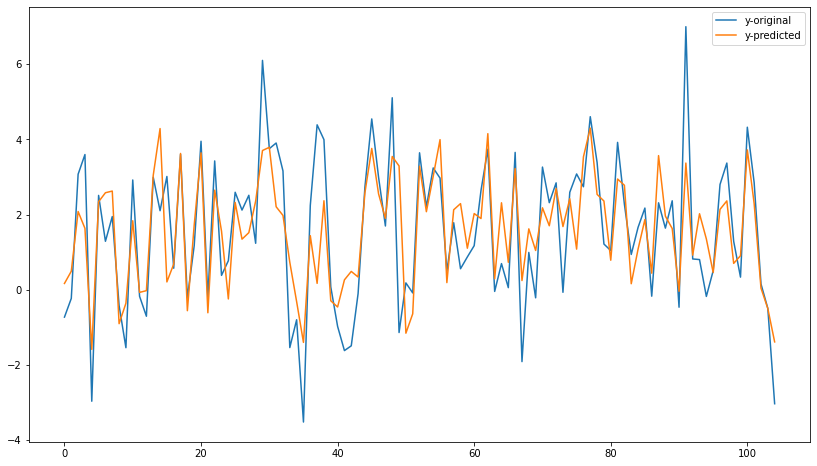

In [61]:
plt.figure(figsize=(14,8))
plt.plot(labels[train_index], label="y-original")
plt.plot(y_train, label="y-predicted")
plt.legend()
plt.show()

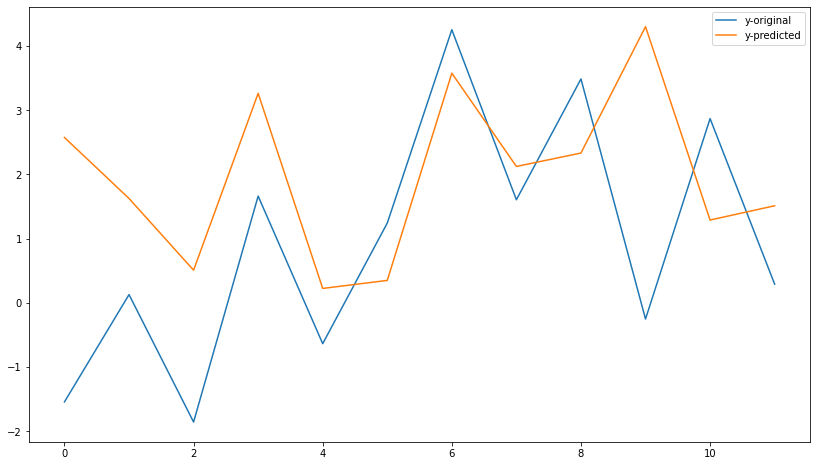

In [62]:
plt.figure(figsize=(14,8))
plt.plot(labels[test_index], label="y-original")
plt.plot(y_test, label="y-predicted")
plt.legend()
plt.show()

stopped attempt of funcitonaizing error computation

In [24]:
dict =	{
    "mae_train": [],
    'mad_train': [],
    'mse_train': [],
    'rmse_train': [],
    'corr_train': []
}


dict['mae_train'] = np.append (dict['mae_train'], 1)

def errors (string):
    
    dict[f'mae_{string}'] = np.append (dict[f'mae_{string}'], np.mean(ae_test))
    dict[f'mad_{string}'] = np.append(f'mad_{string}', np.median(np.absolute(e_train - np.median(e_train))))
    dict[f'mse_{string}'] = np.append(f'mse_{string}', np.mean(e_train**2))
    dict[f'rmse_{string}'] = np.append(f'rmse_{string}', np.sqrt(mse_train))
    dict[f'corr_{string}'] = np.append(f'corr_{string}', st.pearsonr(y_train, labels[train_index])[0])
